# Introduction to PFJAX

**Martin Lysy -- University of Waterloo**

**September 1, 2022**

## Summary

The goal of **PFJAX** is to provide tools for estimating the parameters $\tth$ of a [state-space model](http://www.scholarpedia.org/article/State_space_model)

$$
\begin{aligned}
\xx_0 & \sim \pi(\xx_0 \mid \tth) \\
\xx_t & \sim f(\xx_t \mid \xx_{t-1}, \tth) \\
\yy_t & \sim g(\yy_t \mid \xx_t, \tth).
\end{aligned}
$$

In such models, only the *measurement variables* $\yy_{0:T} = (\yy_0, \ldots, \yy_T)$ are observed, whereas the *state variables* $\xx_{0:T}$ are latent.  The marginal likelihood given the observed data is

$$
\begin{aligned}
\Ell(\tth) & = p(\yy_{0:T} \mid \tth) \\
& = \int \pi(\xx_0 \mid \tth) \times \prod_{t=0}^T g(\yy_t \mid \xx_t, \tth) \times \prod_{t=1}^T f(\xx_t \mid \xx_{t-1}, \tth) \ud \xx_{0:T},   
\end{aligned}
$$

but this integral is typically intractable.  The state-of-the-art for approximating it is via [particle filtering methods](https://warwick.ac.uk/fac/sci/statistics/staff/academic-research/johansen/publications/dj11.pdf).  **PFJAX** provides several particle filters to estimate the marginal loglikelihood $\ell(\tth) = \log \Ell(\tth)$, along with its gradient $\nabla \ell(\tth) = \frac{\partial}{\partial \tth} \ell(\tth)$ and hessian $\nabla^2 \ell(\tth) = \frac{\partial^2}{\partial \tth \partial \tth'} \ell(\tth)$.  To do this efficiently, **PFJAX** uses JIT-compilation and automatic differentiation as provided by the [**JAX**](https://github.com/google/jax) library.

In this tutorial, we'll show how to use **PFJAX** to:

- Create a state-space model class inheriting from `pfjax.BaseModel`.

- Use this class to simulate data this state-space model via `pfjax.simulate()`.

- Use a basic particle filter `pfjax.particle_filter()` to estimate the marginal loglikelihood $\ell(\tth)$.


<!-- - Simulate data from a state space model and estimate its marginal loglikelihood $\ell(\tth)$.

- Approximate the maximum likelihood estimator $\hat \tth = \argmax_{\tth} \ell(\tth)$ and its variance $\var(\hat \tth)$ via stochastic optimization.

- Calculate the posterior distribution $p(\tth \mid \yy_{0:T}) \propto \Ell(\tth) \times \pi(\tth)$ via Markov chain Monte Carlo (MCMC) sampling. -->

In [1]:
# jax
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random
from functools import partial
# plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import projplot as pjp
# pfjax
import pfjax as pf

## Example Model: Brownian Motion with Drift

The model is

$$
\begin{aligned}
x_0 & \sim \N(0, \sigma^2 \dt) \\
x_t & \sim \N(x_{t-1} + \mu \dt, \sigma^2 \dt) \\
y_t & \sim \N(x_t, \tau^2).
\end{aligned}
$$

The parameters of the model are $\tth = (\mu, \sigma, \tau)$.  Since $(\xx_{0:T}, \yy_{0:T})$ are jointly normal given $\tth$, we can show (see [here](#bm_deriv)) that $\yy_{0:T}$ is multivariate normal with mean and covariance 

$$
\begin{aligned}
E[y_t \mid \tth] & = \tilde \mu t, \\ 
\cov(y_s, y_t) & = \tilde \sigma^2 \cdot (1 + \min(s, t)) + \tau^2 \delta_{st},
\end{aligned}
$$

where $\tilde \mu = \mu \dt$, $\tilde \sigma^2 = \sigma^2 \dt$, and $\delta_{st}$ is the indicator function.  These formulas provide an analytic expression for $\Ell(\tth) = p(\yy_{0:T} \mid \tth)$, which we can use to benchmark our calculations.  

## Particle Filter Approximation of the Marginal Loglikelihood

Using the particle filters provided by **PFJAX** requires at minimum that a class defining the state-space model be provided.  This can be done by deriving from a base class `pfjax.BaseModel` as done in the example code below.  

- The methods `{prior/state/meas}_{lpdf/sample}()` and their argument inputs and outputs must be as below for the machinery of **PFJAX** to operate correctly. 
- In this case we can directly compare the particle filter loglikelihood approximation $\hat \ell(\tth)$ to the true loglikelihood $\ell(\tth)$ defined the formulas above, so we'll also add a method `exact_lpdf()` defining $\ell(\tth)$ to the derived class below.

In [2]:
class BMModel(pf.BaseModel):

    def __init__(self, dt):
        """
        Class constructor.

        Args:
            dt: JAX scalar specifying the interobservation time.
        """
        super().__init__(bootstrap=True)  # Sets up a so-called bootstrap filter.  See details below.
        self._dt = dt

    def prior_lpdf(self, x_init, theta):
        """
        Calculate the log-density of the initial state variable at time `t=0`.
        """
        scale = theta[1] * jnp.sqrt(self._dt)
        return jsp.stats.norm.logpdf(x_init, loc=0.0, scale=scale)

    def prior_sample(self, key, theta):
        """
        Sample one draw from the initial state variable at time `t=0`.
        """
        scale = theta[1] * jnp.sqrt(self._dt)
        return scale * jax.random.normal(key=key)

    def state_lpdf(self, x_curr, x_prev, theta):
        """
        Calculate the log-density of the current state variable at time `t` given the previous state variable at time `t-1`.
        """
        loc = x_prev + theta[0] * self._dt
        scale = theta[1] * jnp.sqrt(self._dt)
        return jsp.stats.norm.logpdf(x_curr, loc=loc, scale=scale)

    def state_sample(self, key, x_prev, theta):
        """
        Sample one draw from the current state variable at time `t` given the previous state variable at time `t-1`.
        """
        loc = x_prev + theta[0] * self._dt
        scale = theta[1] * jnp.sqrt(self._dt)
        return loc + scale * jax.random.normal(key=key)

    def meas_lpdf(self, y_curr, x_curr, theta):
        """
        Calculate the log-density of the current measurement variable at time `t` given the current state variable at time `t`.
        """
        loc = x_curr
        scale = theta[2]
        return jsp.stats.norm.logpdf(y_curr, loc=loc, scale=scale)

    def meas_sample(self, key, x_curr, theta):
        """
        Sample one draw from the current measurement variable at time `t` given the current state variable at time `t`.
        """
        loc = x_curr
        scale = theta[2]
        return loc + scale * jax.random.normal(key=key)

    def exact_lpdf(self, y_meas, theta):
        """
        Calculate exact log-density of measurement variables at times `t=0:T`.
        """
        mu_tilde = theta[0] * self._dt
        sigma2_tilde = theta[1] * theta[1] * self._dt
        tau2 = theta[2] * theta[2]
        n_obs = y_meas.shape[0]  # number of observations
        t_meas = jnp.arange(n_obs)
        mu_y = mu_tilde * t_meas  # mean of y_meas
        # variance of y_meas
        Sigma_y = sigma2_tilde * \
            jax.vmap(lambda t: jnp.minimum(t, t_meas))(t_meas)
        Sigma_y = Sigma_y + sigma2_tilde
        Sigma_y = Sigma_y + tau2 * jnp.eye(n_obs)
        return jsp.stats.multivariate_normal.logpdf(
            x=y_meas, mean=mu_y, cov=Sigma_y
        )

### Simulate Data

This is accomplished with the function `pfjax.simulate()`.

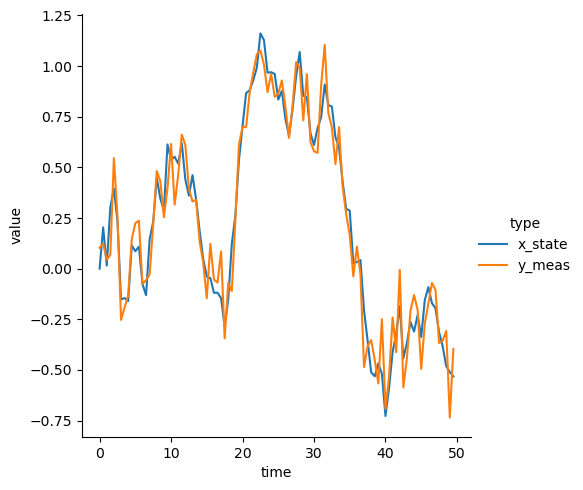

In [3]:
# parameter values
mu = 0.
sigma = .2
tau = .1
theta_true = jnp.array([mu, sigma, tau])

# data specification
dt = .5
n_obs = 100
x_init = jnp.array(0.)

# initial key for random numbers
key = jax.random.PRNGKey(0)

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = jax.random.split(key)
y_meas, x_state = pf.simulate(
    model=bm_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true
)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)

### Calculate Particle Filter Marginal Logikelihood

For this we will use the basic particle filter provided by `pfjax.particle_filter()`.  We'll also compare the particle filter approximation $\hat{\ell}(\tth)$ to the exact loglikelihood $\ell(\tth)$ using "projection plots", i.e., we'll plot the one-dimensional marginal loglikelihood in each of the parameters $\tth = (\mu, \sigma, \tau)$ with the other two parameters fixed at their simulated values.  

- Projection plots are obtained with the help of the **projplot** package.
- Projection plots involve a fairly large number of evaluations of $\hat{\ell}(\tth)$, which itself involes $\bO(TN)$ evaluations of the state-space model functions $f(\xx_t \mid \xx_{t-1}, \tth)$ and $g(\yy_t \mid \xx_t, \tth)$.  We will therefore employ the JIT compilation engine offered by **JAX** to massively speed up function evaluations.

1.12 s ± 12.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.94 ms ± 40.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


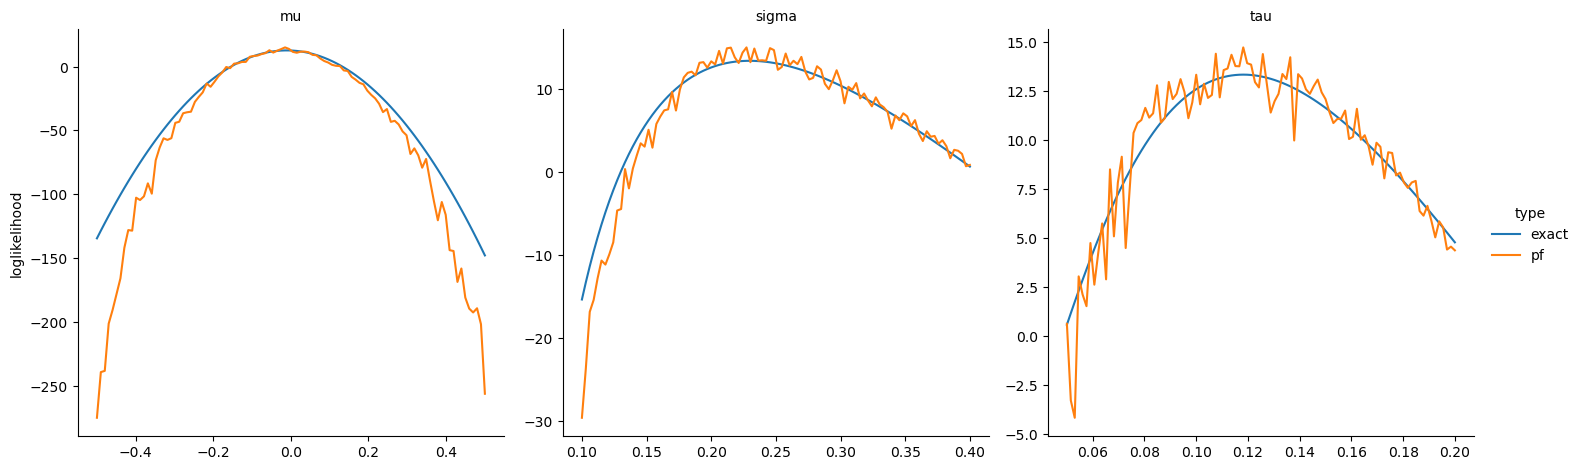

In [5]:
# particle filter specification
n_particles = 200 # number of particles

def bm_loglik_pf_nojit(theta, key):
    """
    Particle filter loglikelihood of the BM model (un-jitted).
    """
    pf_out = pf.particle_filter(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        n_particles=n_particles,
        theta=theta,
        history=False,
        score=False,
        fisher=False
    )
    return pf_out["loglik"]

# jitted version
bm_loglik_pf_jit = jax.jit(bm_loglik_pf_nojit)

# check jit speedup
key, subkey = jax.random.split(key)
%timeit bm_loglik_pf_nojit(theta=theta_true, key=subkey)
%timeit bm_loglik_pf_jit(theta=theta_true, key=subkey)

@jax.jit
def bm_loglik_exact(theta):
    """
    Exact loglikelihood of the BM model (jitted).
    """
    return bm_model.exact_lpdf(theta=theta, y_meas=y_meas)

# projection plot specification
n_pts = 100 # number of evaluation points per plot
theta_lims = jnp.array([[-.5, .5], [.1, .4], [.05, .2]])  # plot limits for each parameter
theta_names = ["mu", "sigma", "tau"] # parameter names

# calculate projection plot for exact loglikelihood
df_exact = pjp.proj_plot(
    fun=bm_loglik_exact,
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    plot=False
)

# calculate projection plot for particle filter loglikelihood
df_pf = pjp.proj_plot(
    fun=partial(bm_loglik_pf_jit, key=subkey),
    x_opt=theta_true, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=n_pts,
    plot=False
)

# merge data frames and plot them
plot_df = pd.concat([df_exact, df_pf], ignore_index=True)
plot_df["type"] = np.repeat(["exact", "pf"], len(df_exact["variable"]))
plot_df = plot_df.rename(columns={"y": "loglikelihood"})
rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="loglikelihood", 
    hue="type",
    col="variable",
    col_wrap = 3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.set_titles(col_template="{col_name}")
rp.set(xlabel=None)

**NOTE:** We see in this case that the particle filter loglikelihood approximation is extremely accurate.  However, it seems to be biased a bit (i.e., not centered at the true loglikelihood).  However, this is mostly due to the fact that we used the same random seed for every evaluation of $\ell(\tth)$ in the projection plots.  Technically we should have been using different seeds -- this is possible with **projplot** but slighly more complicated than the code above. 

<a id="bm_deriv"></a>
## Appendix: Exact Likelihood of the BM Model

The distribution of $p(\xx_{0:T}, \yy_{0:T} \mid \tth)$ is multivariate normal.  Thus, $p(\yy_{0:T} \mid \tth)$ is also multivariate normal, and we only need to find $E[y_t \mid \tth]$ and $\cov(y_s, y_t \mid \tth)$.

Conditioned on $x_0$ and $\tth$, the Brownian latent variables $\xx_{1:T}$ are multivariate normal with

$$
\newcommand{\cov}{\operatorname{cov}}
\begin{aligned}
E[x_t \mid x_0, \tth] & = x_0 + \tilde \mu t, \\
\cov(x_s, x_t \mid x_0, \tth) & = \tilde \sigma^2 \min(s, t),
\end{aligned}
$$

where $\tilde \mu = \mu \dt$ and $\tilde \sigma^2 = \sigma^2 \dt$.

Therefore, $p(\xx_{0:T} \mid \tth)$ is multivariate normal with

$$
\begin{aligned}
E[x_t \mid \tth] & = E[E[x_t \mid x_0, \tth]] \\
& = \tilde \mu t, \\
\cov(x_s, x_t \mid \tth) & = \cov(E[x_s \mid x_0, \tth], E[x_t \mid x_0, \tth]) + E[\cov(x_s, x_t \mid x_0, \tth)] \\
& = \tilde \sigma^2 (1 + \min(s, t)).
\end{aligned}
$$

Similarly, conditioned on $\xx_{0:T}$ and $\tth$, the measurement variables $\yy_{0:T}$ are multivariate normal with

$$
\begin{aligned}
E[y_t \mid \xx_{0:T}, \tth] & = x_t, \\
\cov(y_s, y_t \mid \xx_{0:T}, \tth) & = \tau^2 \delta_{st}.
\end{aligned}
$$

Therefore, $p(\yy_{0:T} \mid \tth)$ is multivariate normal with

$$
\begin{aligned}
E[y_t \mid \tth] & = \tilde \mu t, \\
\cov(y_s, y_t \mid \tth) & = 
% \cov(E[y_s \mid \xx_{0:T}, \tth], E[y_t \mid \xx_{0:T}, \tth]) + E[\cov(y_s, y_t \mid \xx_{0:T}, \tth)] \\
\tilde \sigma^2 (1 + \min(s, t)) + \tau^2 \delta_{st}.
\end{aligned}
$$